In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
#import imageio
import imageio.v2 as imageio
from matplotlib.lines import Line2D
from PIL import Image
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
plt.rcParams["mathtext.fontset"] = "cm"

path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(loc=2,column="Spherical",value=["No Spherical"]*len(DB5))
DB5.loc[(DB5[DB5.TOK.isin(['START','MAST','NSTX'])].index), "Spherical"] = "Spherical"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
DB5 = tokamakTK.clean_categorical_data(DB5)


def get_HUEORDER(DB5,c="tab20"):
    # Needed for Improved Visualization: 2D and 3D Plots
    HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5,c)
    hue_order = HUEOrder(HUE_ORDER)

    # ---------------------------------------------------

    # SPECIAL PARAMETERS
    colors_ = sns.color_palette(c, 20)
    HUE_ORDER["Spherical"] = dict(zip(sorted(DB5["Spherical"].unique()), colors_[:len(DB5["Spherical"].unique())]))
    HUE_ORDER["label_joe"] = dict(zip(sorted(DB5["label_joe"].unique()), colors_[:len(DB5["label_joe"].unique())]))
    HUE_ORDER["TOK"]["START"] = (0.8235, 0.5055, 0.4412)
    
    return HUE_ORDER, PX_ORDER

HUE_ORDER, PX_ORDER = get_HUEORDER(DB5)

In [5]:
data1 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)
data2 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1,data2]

In [ ]:
len(data1)+len(data2)#+len(DB2)

In [ ]:
def get_3D_plot_DB5(db5, indxs, parameter, saveFig=False, file_name="", remSPH=False):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "Q95"
    
    y_sp = (11, 20, 13)
    if remSPH:
        data = data[~data.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
        if parameter=="TOK":
            HUE_ORDER[parameter].pop('START')
            HUE_ORDER[parameter].pop('MAST')
            HUE_ORDER[parameter].pop('NSTX')
            print("Remember to re-run HUE_ORDER")
    
    data["colors"] = data[parameter].map(HUE_ORDER[parameter])
    
    scatter = ax.scatter(data[x], data[y], data[z], c=data["colors"].values)
    ax.set_xlabel(x, fontsize=11, labelpad=7)
    ax.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax.set_zlabel(z, fontsize=11, rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=y_sp[2])
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)
    
    # Add a legend
    legend_elements = []
    for category, color in HUE_ORDER[parameter].items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax.legend(handles=legend_elements, frameon=False,
                       loc='upper right', bbox_to_anchor=(1.3, 0.9), fontsize=8)

    
    ax.view_init(elev=15, azim=200)
    
    if saveFig:
        #plt.savefig(path + file_name)
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

In [ ]:
#get_3D_plot_DB5(DB5, min_subset_ids_6357, "WALMAT", saveFig=False, file_name="", remSPH=False)

In [ ]:
#get_3D_plot_DB5(DB5, min_subset_ids_6357, "DIVMAT", saveFig=False, file_name="", remSPH=False)

In [ ]:
def get_twoprms3D_plot_DB5(db5, indxs, rotation, parameters, saveFig=False, file_name="", remSPH=False):
    # Create a figure and a 3D axis
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    HUE_ORDER_0 = get_HUEORDER(db5, parameter, c="tab10").copy()
    HUE_ORDER_1 = get_HUEORDER(db5, parameter, c="Set3").copy()
    
    data = db5.copy()
    data[parameters[0]] = data[parameters[0]].str.replace("UNKNOWN","UNK.", regex=False)
    data[parameters[1]] = data[parameters[1]].str.replace("UNKNOWN","UNK.", regex=False)
    
    HUE_ORDER_0[parameters[0]]["UNK."] = HUE_ORDER_0[parameters[0]]["UNKNOWN"]
    HUE_ORDER_0[parameters[0]].pop("UNKNOWN")
    
    HUE_ORDER_1[parameters[1]]["UNK."] = HUE_ORDER_1[parameters[1]]["UNKNOWN"]
    HUE_ORDER_1[parameters[1]].pop("UNKNOWN")
    
    HUE_ORDER_0[parameters[0]]["UNK."] = (0, 0, 0)
    HUE_ORDER_1[parameters[1]]["UNK."] = (0, 0, 0)
    
    x, y, z = "NUSTAR", "RHOSTAR", "Q95"
    
    y_sp = (11, 20, 13)
    if remSPH:
        data = data[~data.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
        if parameters[0]=="TOK":
            HUE_ORDER_0[parameters[0]].pop('START')
            HUE_ORDER_0[parameters[0]].pop('MAST')
            HUE_ORDER_0[parameters[0]].pop('NSTX')
            print("Remember to re-run HUE_ORDER")
        elif parameters[1]=="TOK":
            HUE_ORDER_1[parameters[1]].pop('START')
            HUE_ORDER_1[parameters[1]].pop('MAST')
            HUE_ORDER_1[parameters[1]].pop('NSTX')
            print("Remember to re-run HUE_ORDER")
    
    data["colors1"] = data[parameters[0]].map(HUE_ORDER_0[parameters[0]])
    data["colors2"] = data[parameters[1]].map(HUE_ORDER_1[parameters[1]])
    

    fig = plt.figure(figsize=(13, 4.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Adjust subplot positions
    fig.subplots_adjust(wspace=0.05)
    
    
    scatter = ax1.scatter(data[x], data[y], data[z], c=data["colors1"].values)
    ax1.set_xlabel(x, fontsize=11, labelpad=7)
    ax1.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax1.set_zlabel(z, fontsize=11, rotation=90)  
    ax1.tick_params(axis='x', labelsize=13)
    ax1.tick_params(axis='y', labelsize=y_sp[2])
    ax1.tick_params(axis='z', labelsize=13)
    
    ax1.set_yticks(ax1.get_yticks())
    ax1.set_yticklabels(ax1.get_yticks(), rotation=45)


    ax1.view_init(elev=15, azim=rotation)


    # GETTING THE SECOND PLOT


    scatter = ax2.scatter(data[x], data[y], data[z], c=data["colors2"].values)
    ax2.set_xlabel(x, fontsize=11, labelpad=7)
    ax2.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax2.zaxis.set_label_text(z, fontsize=11, rotation=90)  
    ax2.tick_params(axis='x', labelsize=13)
    ax2.tick_params(axis='y', labelsize=y_sp[2])
    ax2.tick_params(axis='z', labelsize=13)
    
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(ax2.get_yticks(), rotation=45)
    
    ax2.view_init(elev=15, azim=rotation)
    
    # Add a legend | COMMENT WHEN ROTATING
    
    legend_elements = []
    for category, color in HUE_ORDER_0[parameters[0]].items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax1.legend(handles=legend_elements, frameon=False,
                       loc='upper right', bbox_to_anchor=(1.27, 0.9), fontsize=8)
    
    legend_elements = []
    for category, color in HUE_ORDER_1[parameters[1]].items():
        legend_elements.append(plt.Line2D([1], [1], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax2.legend(handles=legend_elements, frameon=False,
                       loc='upper right', bbox_to_anchor=(1.27, 0.9), fontsize=8)
    
    ax1.annotate(parameters[0], xy=(1, 0.9), xycoords='axes fraction',
                 fontsize=10, fontweight='bold')
    ax2.annotate(parameters[1], xy=(1, 0.9), xycoords='axes fraction',
                 fontsize=10, fontweight='bold')
    
    
    if saveFig:
        plt.savefig(path + file_name)
        #plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

In [ ]:
#get_two3D_plot_DB5(DB5, min_subset_ids_6357, 200, ["WALMAT", "DIVMAT"], 
#                   saveFig=True, file_name="Material_Analysis.pdf", remSPH=False)

In [ ]:
#get_two3D_plot_DB5(DB5, min_subset_ids_6357, 200, ["WALMAT", "DIVMAT"])

## Two Params

```Python
for r in np.linspace(0,360, 360//2):
    file_name = f"GIF_images/image_{int(r)}.png"
    get_two3D_plot_DB5(DB5, min_subset_ids_6357, int(r),
                       ["WALMAT", "DIVMAT"], saveFig=True, file_name=file_name
                      )

x,y,z = "NUSTAR", "RHOSTAR", "Q95"

image_folder = path+"GIF_images/"  # Path to the folder containing the images
output_file = path+"/GIFs/"+f"roMAT{x[0]}{y[0]}{z[0]}.gif"  # Output file name

# Get a list of PNG files in the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
# Sort the image files by their numerical values in the filenames
image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# Save the images in the folder as an animated GIF
imageio.mimsave(output_file, [imageio.imread(file) for file in image_files], fps=7)
```

In [214]:
import pdb # For debugging || pdb.set_trace()

def get_twods3D_plot_DB5(db5, data, rotation, parameter, stationary=True, saveFig=False, file_name="", remSPH=False):
    
    
    colors_dict = { # LIMMAT
        'NONE': '#FF0000',
        'BE': '#0000FF',
        'C': '#A84547',
        'C/W': '#CCCC00',
        'MO': '#ADD8E6',
        'W': '#FF8C00',
        'UNK.': '#000000',
    }
    
    
    """colors_dict = { # WALMAT
        'AL':  '#FF0000',
        'C':   '#A84547',
        'C/SS':'#800080',
        'C/W': '#CCCC00',
        'IN':  '#0000FF',
        'IN/C':'#ADD8E6',
        'SS':  '#FA8072',
        'W':   '#FF8C00',
        'UNK.':'#000000'
    }
    
    # ['NONE', 'C', 'C/W', 'W', 'MO', 'BE', 'UNKNOWN'] | LIMMAT
    
    
    HUE_ORDER = get_HUEORDER(db5, c="tab10")[0].copy()
    colors_dict = HUE_ORDER[parameter]
    HUE_ORDER[parameter]["UNK."] = (0,0,0)
    HUE_ORDER[parameter].pop("UNKNOWN")"""
    
    
    db5_  = db5.copy()
    data1 = data[0].copy()
    data2 = data[1].copy()
        
    data1[parameter] = data1[parameter].str.replace("UNKNOWN","UNK.", regex=False)
    data2[parameter] = data2[parameter].str.replace("UNKNOWN","UNK.", regex=False)
    
    
    x, y, z = "RHOSTAR", "Q95", "TAUTH"
    
    y_sp = (11, 20, 12)
    if remSPH:
        data1 = data1[~data1.TOK.isin(['START','MAST','NSTX'])]
        data2 = data2[~data2.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
    
    data1["colors"] = data1[parameter].map(colors_dict) 
    data2["colors"] = data2[parameter].map(colors_dict)
    
    fig = plt.figure(figsize=(13, 4.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Adjust subplot positions
    fig.subplots_adjust(wspace=0.05)
    
    
    scatter = ax1.scatter(data1[x], data1[y], data1[z], c=data1["colors"].values)
    ax1.set_xlabel(x, fontsize=11, labelpad=11)
    ax1.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax1.set_zlabel(z, fontsize=11, rotation=90)  
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=y_sp[2])
    ax1.tick_params(axis='z', labelsize=12)
    
    """ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation=-35)
    
    ax1.set_yticks(ax1.get_yticks())
    ax1.set_yticklabels(ax1.get_yticks(), rotation=35)"""
    ax1.view_init(elev=15, azim=rotation)


    # GETTING THE SECOND PLOT
    scatter = ax2.scatter(data2[x], data2[y], data2[z], c=data2["colors"].values)
    ax2.set_xlabel(x, fontsize=11, labelpad=11)
    ax2.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax2.zaxis.set_label_text(z, fontsize=11, rotation=90)  
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=y_sp[2])
    ax2.tick_params(axis='z', labelsize=12)
    
    """ax2.set_xticks(ax2.get_xticks())
    ax2.set_xticklabels(ax2.get_xticks(), rotation=-35)
    
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(ax2.get_yticks(), rotation=35)"""
    ax2.view_init(elev=15, azim=rotation)
    
    if stationary:
        legend_elements = []
        for category, color in colors_dict.items():
            legend_elements.append(plt.Line2D([1], [1], marker='o', 
                                   color='w', label=category, markerfacecolor=color, markersize=7))
        legend = ax1.legend(handles=legend_elements, frameon=False,
                 loc='upper right', bbox_to_anchor=(1.3, 0.9), fontsize=9)
        ax1.annotate(parameter, xy=(1.05, 0.9), xycoords='axes fraction',
                 fontsize=10, fontweight='bold')
    else:
        for i in range(len(colors_dict)):
            ax1.annotate(list(colors_dict.keys())[i], xy=(1.12, 0.84-0.05*i), xycoords='axes fraction',
                 fontsize=12, fontweight='bold', color=list(colors_dict.values())[i])
        ax1.annotate(parameter, xy=(1.1, 0.9), xycoords='axes fraction',
                 fontsize=12)
        
    ax1.annotate("DB2", xy=(0.17, 0.87), xycoords='axes fraction',
                 fontsize=12)
    ax2.annotate("STDB5 New", xy=(0.6, 0.86), xycoords='axes fraction',
                 fontsize=12)
        
    """ax1.annotate("Decreasing\n  $\\alpha_R \\sim 0.64$", xy=(0.17, 0.87), xycoords='axes fraction',
                 fontsize=12)
    ax2.annotate("Unaffected\n  $\\alpha_R \\sim 2.16$", xy=(0.6, 0.86), xycoords='axes fraction',
                 fontsize=12)"""
    
    ax1.set_xlabel(x, fontsize=11, labelpad=11)
    ax1.set_ylabel(y, fontsize=11, labelpad=11)
    ax1.set_zlabel(z, fontsize=11, labelpad=11)
    
    ax2.set_xlabel(x, fontsize=11, labelpad=11)
    ax2.set_ylabel(y, fontsize=11, labelpad=11)
    ax2.set_zlabel(z, fontsize=11, labelpad=11)
    
    ax2.set_xlim(0, max(data2[x]))
    ax1.set_xlim(0, max(data2[x]))
    
    ax2.set_ylim(0, max(data2[y])+0.7)
    ax1.set_ylim(0, max(data2[y])+0.7)
    
    ax2.set_zlim(0, max(data1[z]))
    ax1.set_zlim(0, max(data1[z]))
    
    ax2.set_xticks(ax2.get_xticks())
    ax2.set_xticklabels(ax2.get_xticks(), rotation=-15)
    
    ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation=-15)
    
    #ax1.set_title("Decreasing\n$\\alpha_R \\sim 0.64$")
    #ax2.set_title("Unaffected\n$\\alpha_R \\sim 2.16$")
    
    if saveFig:
        #plt.savefig(path + file_name, format="png")
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

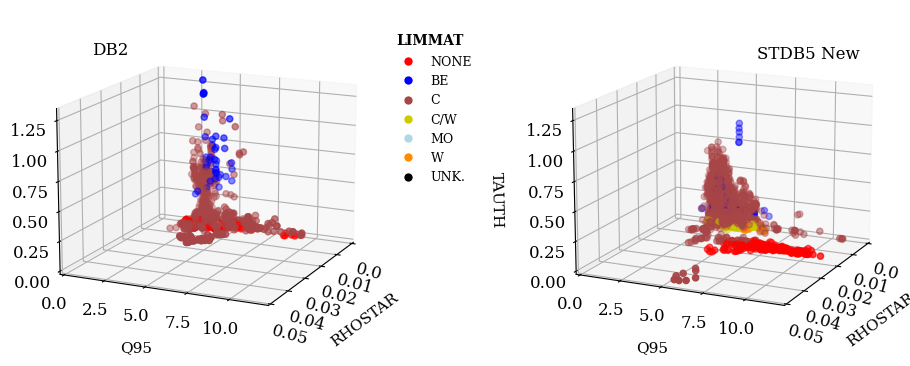

In [216]:
get_twods3D_plot_DB5(DB5, [DB5[DB5.id.isin(DB2.id.values)], 
                           DB5[~DB5.id.isin(DB2.id.values)]],
                     25, "LIMMAT", stationary=True, saveFig=False, file_name="test")

"""get_twods3D_plot_DB5(DB5, data,
                     35, "WALMAT", stationary=True, saveFig=False, file_name="test")""";

In [ ]:
for r in np.linspace(0,360, 360//2):
    file_name = f"GIF_images/image_{int(r)}.png"
    get_twods3D_plot_DB5(DB5, data, int(r), "LIMMAT", stationary=False, 
                         saveFig=True, file_name=file_name, remSPH=False
                        )

In [ ]:
x,y,z = "NUSTAR", "RHOSTAR", "TAUTH"

image_folder = path+"GIF_images/"  # Path to the folder containing the images
output_file = path+"/GIFs/"+f"roLIM{x[0]}{y[0]}{z[0]}.gif"  # Output file name

# Get a list of PNG files in the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
# Sort the image files by their numerical values in the filenames
image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# Save the images in the folder as an animated GIF
imageio.mimsave(output_file, [imageio.imread(file) for file in image_files], fps=7)

In [ ]:
DB5["WALMAT"].unique()

In [ ]:
df_ = DB5[DB5["LIMMAT"].isin(['UNKNOWN'])]#.DIVMAT.unique()

In [ ]:
df_.TOK.unique()

In [ ]:
DB5[DB5.TOK.isin(['JETILW'])].LIMMAT.unique()

In [ ]:
data1[data1["WALMAT"].isin(['IN', 'IN/C'])].DATE.astype(str).apply(lambda x: x[:4]).unique()

In [ ]:
data2[data2["WALMAT"].isin(['IN', 'IN/C'])].DATE.astype(str).apply(lambda x: x[:4]).unique()

In [ ]:
"AUG', 'JT60U', 'MAST', 'NSTX', 'TFTR".replace("'","")

In [ ]:
DB5[DB5.TOK.isin(['JETILW'])]["LIMMAT"].unique()

In [ ]:
max(DB5["TAUTH"])

In [ ]:
max(data1[data1.TOK.isin(['JETILW'])]["TAUTH"])

In [ ]:
max(data2[data2.TOK.isin(['JETILW'])]["TAUTH"])

In [ ]:
max(data1["TAUTH"])

In [ ]:
data1[data1["TAUTH"] > 0.9]["id"]

In [ ]:
DB5[DB5["TAUTH"] > 1.3]["id"]

In [ ]:
DB2[DB2.id.isin(["D30MET"])]

In [225]:
get_ECT_regression(DB2).params

const   -3.004272
IP       0.781188
BT       0.320077
NEL      0.435161
PLTH    -0.668186
RGEO     2.222962
KAREA    0.390074
EPS      0.575613
MEFF     0.179800
dtype: float64

In [221]:
get_ECT_regression(DB5).params

const   -2.518531
IP       1.134330
BT       0.072389
NEL      0.174897
PLTH    -0.682701
RGEO     1.447909
KAREA    0.280227
EPS      0.063554
MEFF     0.214018
dtype: float64

In [222]:
np.exp(-2.518531)

0.08057788876871994

In [223]:
len(DB5)

6252

In [224]:
get_ECT_regression(DB5[~DB5.TOK.isin(["MAST","NSTX","START"])]).params

const   -2.338070
IP       1.227854
BT      -0.037783
NEL      0.146285
PLTH    -0.669058
RGEO     1.281766
KAREA    0.112734
EPS     -0.013563
MEFF     0.233486
dtype: float64

In [227]:
(len(DB5[DB5.TOK.isin(["MAST","NSTX","START"])])/len(DB5))*100

3.7747920665387076